## 1. Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,10)})

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [4]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

In [5]:
import datetime
from scipy.stats import pearsonr

# 2. Data Sourcing

## 2.1. Importing CSV Data from file

In [6]:
data = pd.read_csv('day.csv', index_col='instant')

## 2.2. Checking the dataset

In [7]:
 data.shape


(730, 15)

In [8]:
data.head(7)

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,
1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600
6,06-01-2018,1,0,1,0,4,1,1,8.378268,11.66045,51.8261,6.000868,88,1518,1606
7,07-01-2018,1,0,1,0,5,1,2,8.057402,10.44195,49.8696,11.304642,148,1362,1510


## 2.3. Checking for Null Values

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 1 to 730
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      730 non-null    object 
 1   season      730 non-null    int64  
 2   yr          730 non-null    int64  
 3   mnth        730 non-null    int64  
 4   holiday     730 non-null    int64  
 5   weekday     730 non-null    int64  
 6   workingday  730 non-null    int64  
 7   weathersit  730 non-null    int64  
 8   temp        730 non-null    float64
 9   atemp       730 non-null    float64
 10  hum         730 non-null    float64
 11  windspeed   730 non-null    float64
 12  casual      730 non-null    int64  
 13  registered  730 non-null    int64  
 14  cnt         730 non-null    int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 88.4+ KB


##### No Null value found in any column

# 3. Data Preparation

#####  Defining a Function required for plots

In [10]:
def bar_graph_function(data, graph_title, x_axis_label, y_axis_label, data_label='horizontal', x_label_rotation=0, x_text=None):
    population_graph = sns.barplot(x=data.index, y=data.values)
    label_deviation_above_y_axis = data.max() * 0.015
    for index, value in enumerate(data.iteritems()):
        population_graph.text(index, value[1] + label_deviation_above_y_axis, round(value[1], 2), color='black', ha="center", rotation=data_label)       
    if x_text is None:
        population_graph.set_xticklabels(population_graph.get_xticklabels(), rotation=x_label_rotation)
    else:
        population_graph.set_xticklabels(x_text, rotation=x_label_rotation)
    plt.title(graph_title, fontdict={'fontsize': 20})
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    plt.show()

## 3.1. Date

In [11]:
data.dteday.describe()

count            730
unique           730
top       09-08-2019
freq               1
Name: dteday, dtype: object

#### We will check if any of the date range is outside certain limit

In [12]:
data['dteday'].apply(lambda x: int(x.split('-')[0])).describe()

count    730.000000
mean      15.720548
std        8.802278
min        1.000000
25%        8.000000
50%       16.000000
75%       23.000000
max       31.000000
Name: dteday, dtype: float64

#### We will check if any of the month range is outside certain limit

In [13]:
data['dteday'].apply(lambda x: int(x.split('-')[1])).describe()

count    730.000000
mean       6.526027
std        3.450215
min        1.000000
25%        4.000000
50%        7.000000
75%       10.000000
max       12.000000
Name: dteday, dtype: float64

#### We will check if any of the year range is outside certain limit

In [14]:
data['dteday'].apply(lambda x: int(x.split('-')[2])).describe()

count     730.000000
mean     2018.500000
std         0.500343
min      2018.000000
25%      2018.000000
50%      2018.500000
75%      2019.000000
max      2019.000000
Name: dteday, dtype: float64

#### All the range of date, month & year are in the valid range, hence we can proceed ahead with this column without dropping / changing any records

#### On analysing date column we can see that all the attributes of date except for day are comfortably covered under month & year column.
#### So, we will extract only the date part from this column and use it.

In [15]:
data['dteday'] = data['dteday'].apply(lambda x: int(x.split('-')[0]))


#### Also, we will rename the column name from 'dteday' to 'date'

In [16]:
data = data.rename(columns={"dteday": "date"})

#### Let's plot distribution of Ride Count Mean Across all the days

In [17]:
date_dist = round(data.groupby(by='date').cnt.mean())

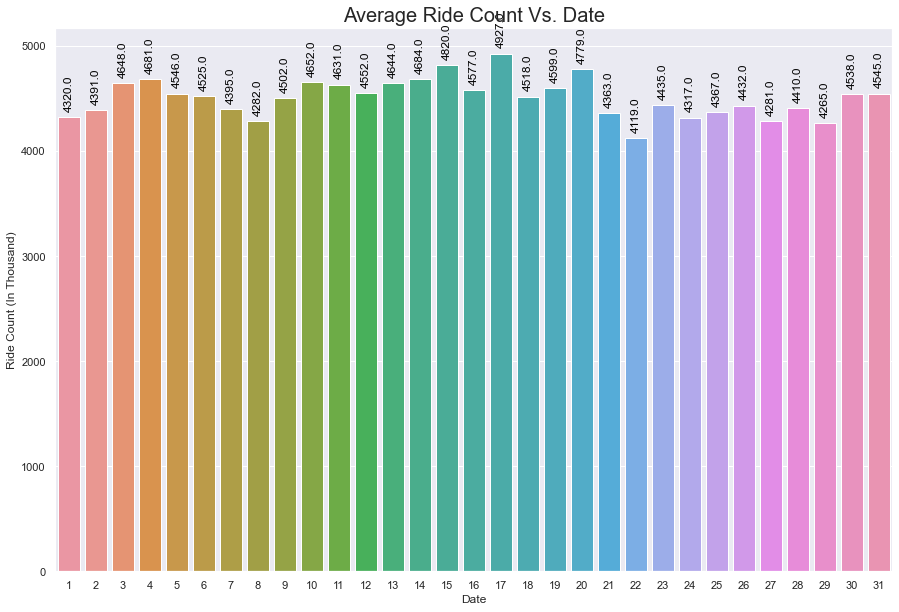

In [18]:
bar_graph_function(data=date_dist, graph_title='Average Ride Count Vs. Date', x_axis_label='Date',
                        y_axis_label='Ride Count (In Thousand)', data_label='vertical', x_label_rotation=0)

#### By simply visualising the Date Column, we dont see any significant impact of this on Ride Count

## 3.2. Season

In [19]:
data.season.describe()

count    730.000000
mean       2.498630
std        1.110184
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: season, dtype: float64

#### Season column varries between 1 to 4 which are properly defined in data dictionary, hence we can proceed ahead with this column without dropping / changing any records

#### Season column is categorical column with each value corresponding to specific season.
#### We need to map these numbers to respectie seasons, so that these column values will be further used to generate dummy variable as it is a Categorical Nominal Type Data

#### We should map this column as follows:
- 1: spring
- 2: summer
- 3: fall
- 4: winter

In [20]:
data['season'] = data['season'].map({1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'})
data['season']

instant
1      spring
2      spring
3      spring
4      spring
5      spring
        ...  
726    spring
727    spring
728    spring
729    spring
730    spring
Name: season, Length: 730, dtype: object

#### Let's plot distrubution of Ride Count Mean Across all the Seasons

In [21]:
season_dist = data.groupby(by='season').cnt.mean()
season_dist

season
fall      5644.303191
spring    2608.411111
summer    4992.331522
winter    4728.162921
Name: cnt, dtype: float64

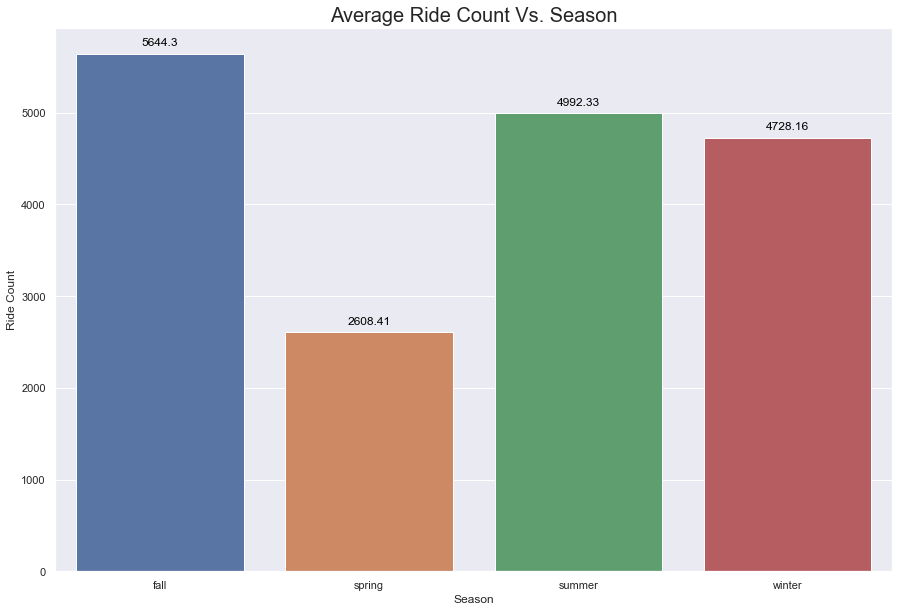

In [22]:
bar_graph_function(data=season_dist, graph_title='Average Ride Count Vs. Season', x_axis_label='Season',
                        y_axis_label='Ride Count', data_label='horizontal', x_label_rotation=0)

#### We see that, distribution is quite different for respective seasons. This might act as a decisive factor.

## 3.3 Year

In [23]:
data.yr.describe()

count    730.000000
mean       0.500000
std        0.500343
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000
Name: yr, dtype: float64

#### Year column is varied between 0 and 1 which are properly defined in data dictionary, hence we can proceed ahead with this column without dropping / changing any records

#### Year column consist of 2 values with 0 corresponding to 2018 & 1 corresponding to 2019.
#### We will keep this values as it is, because normalising column consisting of only 0 & 1 will have no effect.

#### Let's plot distrubution of Ride Count Mean Year-Wise

In [24]:
year_dist = data.groupby(by='yr').cnt.mean()

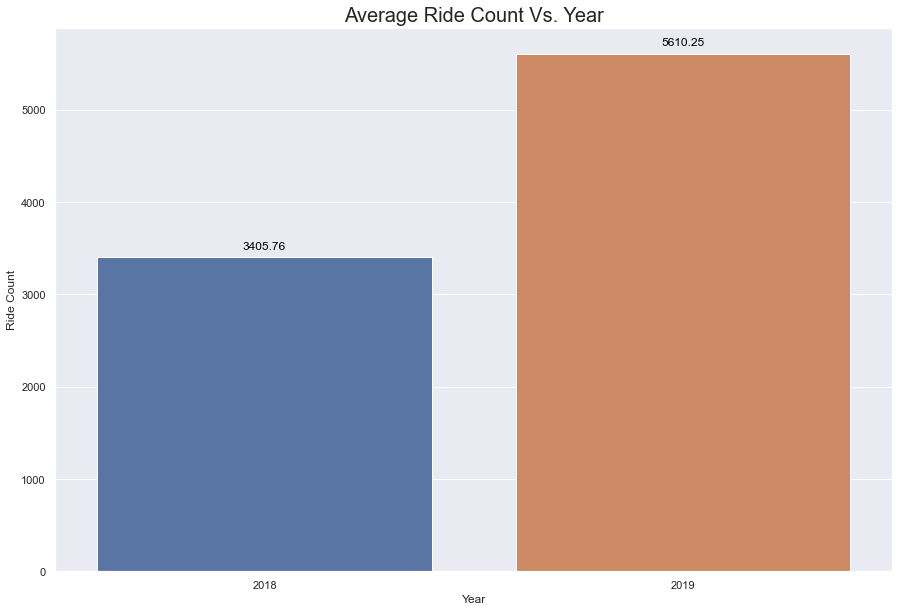

In [25]:
bar_graph_function(data=year_dist, graph_title='Average Ride Count Vs. Year', x_axis_label='Year',
                        y_axis_label='Ride Count', data_label='horizontal', x_label_rotation=0,
                        x_text=['2018', '2019'])

#### We see that, Ride Count has increases comparatively in 2019 as compared to 2018. This can also be decisive factor for predicting target (output)

## 3.4 Month

In [26]:
data.mnth.describe()

count    730.000000
mean       6.526027
std        3.450215
min        1.000000
25%        4.000000
50%        7.000000
75%       10.000000
max       12.000000
Name: mnth, dtype: float64

#### Month column is varied between 1 and 12 which are properly defined in data dictionary, hence we can proceed ahead with this column without dropping / changing any records

#### Let's plot distrubution of Ride Count Mean Across all the months

In [27]:
month_dist = data.groupby(by='mnth').cnt.mean()

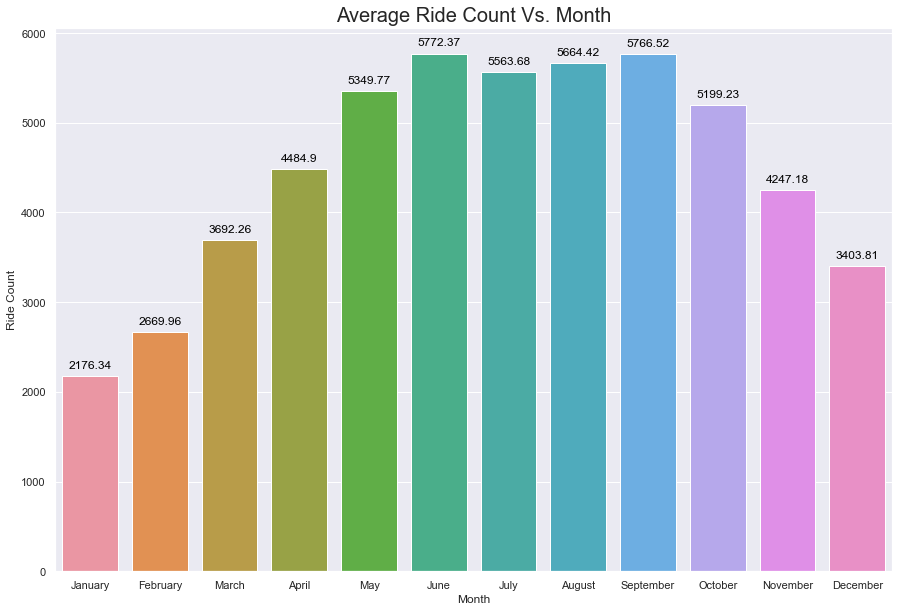

In [28]:
bar_graph_function(data=month_dist, graph_title='Average Ride Count Vs. Month', x_axis_label='Month',
                        y_axis_label='Ride Count', data_label='horizontal', x_label_rotation=0, 
                        x_text=[datetime.date(1900, i , 1).strftime('%B') for i in range(1, 13)])

#### We see that number of Ride Count drastically increases between May to October which are comparatively Summer & Fall Season in US

#### Month column is categorical column with each value corresponding to specific month.
#### Mapping numbers to respective Month Name

In [29]:
data.mnth =data.mnth.apply(lambda x: datetime.date(1900, x , 1).strftime('%B'))


## 3.5 Holiday

In [30]:
data.holiday.describe()

count    730.000000
mean       0.028767
std        0.167266
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: holiday, dtype: float64

#### Holiday column is varied between 0 and 1 which are properly defined in data dictionary, hence we can proceed ahead with this column without dropping / changing any records

#### Let's plot distrubution of Ride Count Mean Across the days which are counted either as holidays or working day

In [31]:
holiday_dist = data.groupby(by='holiday').cnt.mean()
holiday_dist

holiday
0    4530.90268
1    3735.00000
Name: cnt, dtype: float64

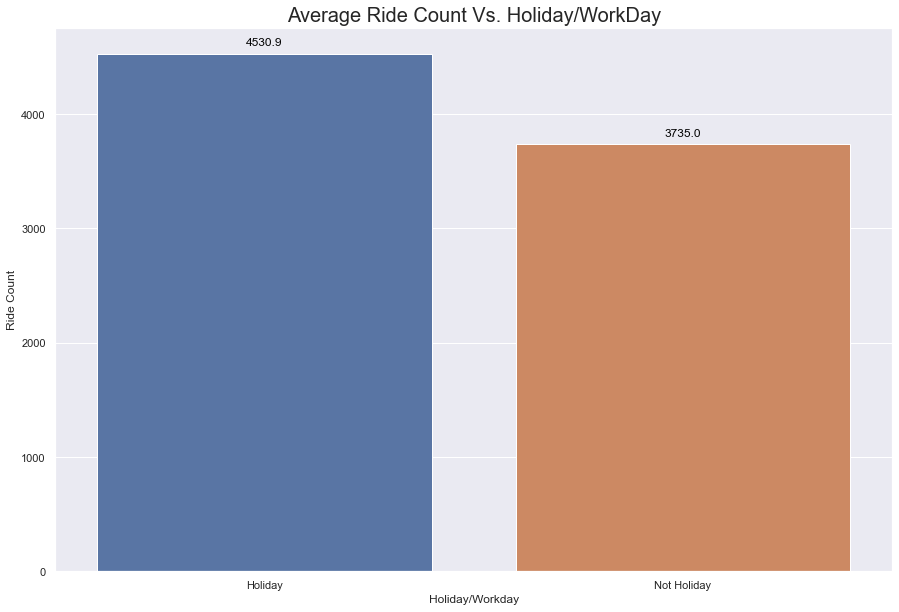

In [32]:
bar_graph_function(data=holiday_dist, graph_title='Average Ride Count Vs. Holiday/WorkDay', x_axis_label='Holiday/Workday',
                        y_axis_label='Ride Count', data_label='horizontal', x_label_rotation=0, 
                        x_text=['Holiday', 'Not Holiday'])

#### Holiday is a Categorical Nomimal Variable. But there are only 2 values, "Yes" or "No" mapped to "1" & "0" respectively.
#### So, we will leave this as it is.

## 3.6 Weekday

In [33]:
data.weekday.describe()

count    730.000000
mean       2.997260
std        2.006161
min        0.000000
25%        1.000000
50%        3.000000
75%        5.000000
max        6.000000
Name: weekday, dtype: float64

#### Weekday column is varied between 1 and 6 which are properly defined in data dictionary, hence we can proceed ahead with this column without dropping / changing any records

In [34]:
data.groupby(by='weekday').weekday.count()

weekday
0    105
1    105
2    104
3    103
4    104
5    104
6    105
Name: weekday, dtype: int64

#### Let's plot distrubution of Ride Count Mean Across the days of weeks (Ex. Sunday, Monday etc.)

In [35]:
weekday_dist = data.groupby(by='weekday').cnt.mean()

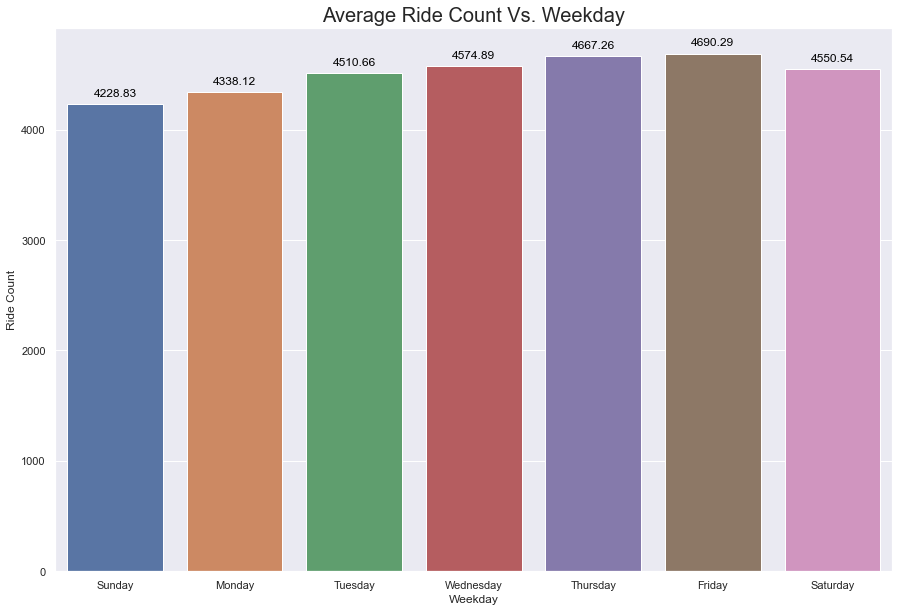

In [36]:
bar_graph_function(data=weekday_dist, graph_title='Average Ride Count Vs. Weekday', x_axis_label='Weekday',
                        y_axis_label='Ride Count', data_label='horizontal', x_label_rotation=0, 
                        x_text=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

#### As per United States, it is usually considered that 1st day of week is Sunday.
#### And also from "Working Day Column", we can see that "Working Day" is marked as "1" for values of 1, 2, 3, 4, 5 in "Week day"
#### From this we can infer that, for weekday column, Sunday is mapped to 0, Monday is mapped to 1 and so on

In [37]:
data['weekday'] = data.weekday.map({0: 'sunday', 1: 'monday', 2: 'tuesday', 3: 'wednesday', 4: 'thursday', 5: 'friday', 6: 'saturday'})


In [38]:
data.groupby(by='weekday').weekday.count()

weekday
friday       104
monday       105
saturday     105
sunday       105
thursday     104
tuesday      104
wednesday    103
Name: weekday, dtype: int64

## 3.7 Working Day

In [39]:
data.workingday.describe()

count    730.000000
mean       0.683562
std        0.465405
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: workingday, dtype: float64

#### Working Day column is varied between 0 and 1 which are properly defined in data dictionary, hence we can proceed ahead with this column without dropping / changing any records

In [40]:
data.groupby(by='workingday').workingday.count()

workingday
0    231
1    499
Name: workingday, dtype: int64

#### Working Day is a Categorical Nomimal Variable. But there are only 2 values, "Yes" or "No" mapped to "1" & "0" respectively.
#### So, we will leave this as it is.

#### Let's plot distrubution of Ride Count Mean Across the days which are working days or not

In [41]:
workingday_dist = data.groupby(by='workingday').cnt.mean()

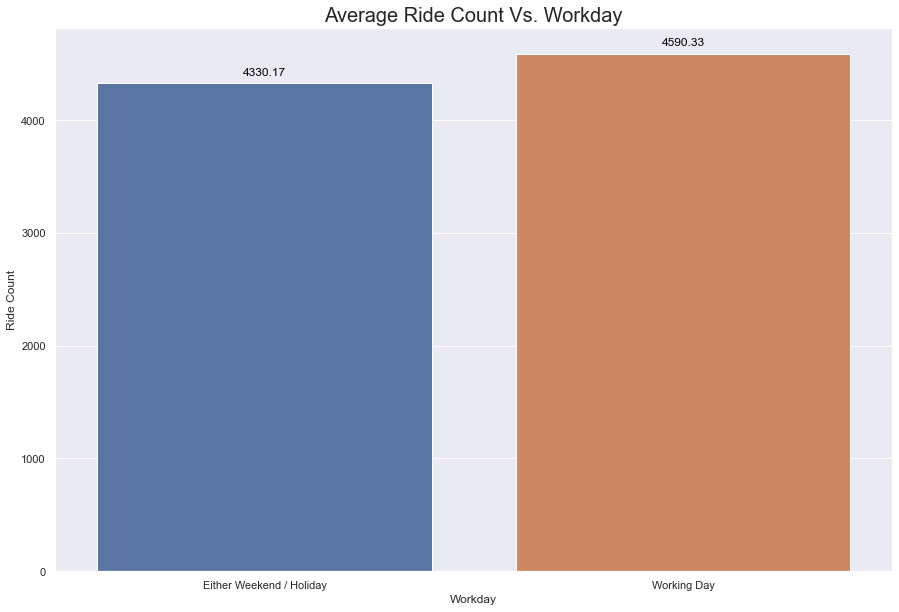

In [42]:
bar_graph_function(data=workingday_dist, graph_title='Average Ride Count Vs. Workday', x_axis_label='Workday',
                        y_axis_label='Ride Count', data_label='horizontal', x_label_rotation=0, 
                        x_text=['Either Weekend / Holiday', 'Working Day'])

## 3.8 Weather Situation

In [43]:
data.weathersit.describe()

count    730.000000
mean       1.394521
std        0.544807
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: weathersit, dtype: float64

#### Weather Situation column is varied between 1 to 3 which are properly defined in data dictionary, hence we can proceed ahead with this column without dropping / changing any records

In [44]:
data.groupby(by='weathersit').weathersit.count().sort_values(ascending=False)

weathersit
1    463
2    246
3     21
Name: weathersit, dtype: int64

#### Weather Situation is a Categorical Nomimal Variable where every number is mapped as follows:
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
#### As per the explanation, we will map each number with a shorter version
- 1: clear
- 2: mist
- 3: light

#### After analysing the column we see that, there are no values corersponding to Heavy Rain. So, after mapping, this value will be completely cancelled out during one hot encoding process.

In [45]:
data['weathersit'] = data.weathersit.map({1: 'clear', 2: 'mist', 3: 'light', 4: 'heavy'})

In [46]:
data.groupby(by='weathersit').weathersit.count()

weathersit
clear    463
light     21
mist     246
Name: weathersit, dtype: int64

#### Let's plot distrubution of Ride Count Mean Across Weather Situation

In [47]:
weathersit_dist = data.groupby(by='weathersit').cnt.mean()

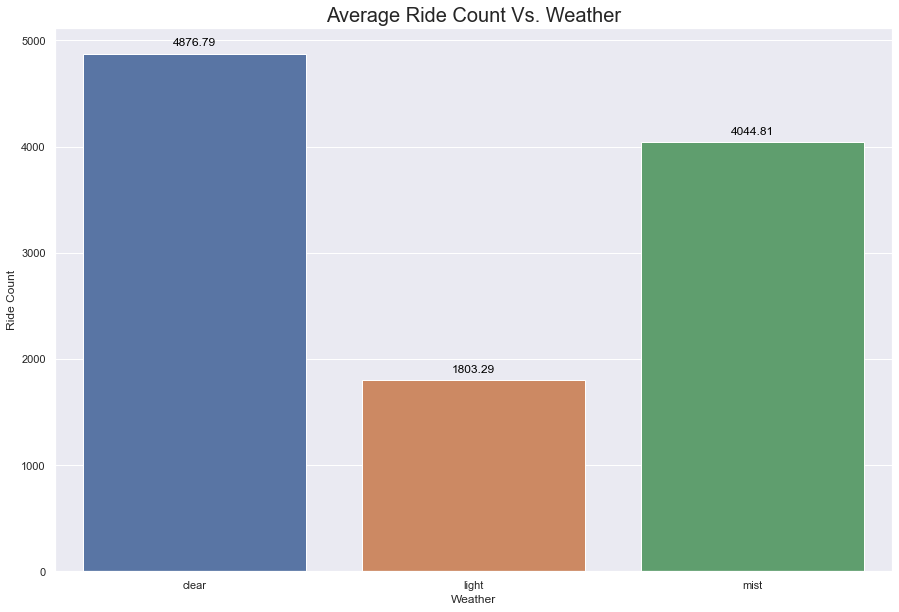

In [48]:
bar_graph_function(data=weathersit_dist, graph_title='Average Ride Count Vs. Weather', x_axis_label='Weather',
                        y_axis_label='Ride Count', data_label='horizontal', x_label_rotation=0)

## 3.9 Temperate & Adjusted Temperature

#### We see that there is high correlation that appears between Temperature & Adjusted Temperature by just visualising the columns

In [49]:
headers = ['Temperature', 'Adjusted Temperature']
pd.DataFrame(np.corrcoef(data['temp'], data["atemp"]), index=headers, columns=headers)    

,Temperature,Adjusted Temperature
Temperature,1.000000,0.991696
Adjusted Temperature,0.991696,1.000000


#### We will go ahead and drop "Adjusted Temperature" column as any one can be dropped since they are highly correlated and provide almost same explanation

In [50]:
data = data.drop(columns=['atemp'])

In [51]:
data.temp.describe()

count    730.000000
mean      20.319259
std        7.506729
min        2.424346
25%       13.811885
50%       20.465826
75%       26.880615
max       35.328347
Name: temp, dtype: float64

Text(0.5, 0, 'Temperature')

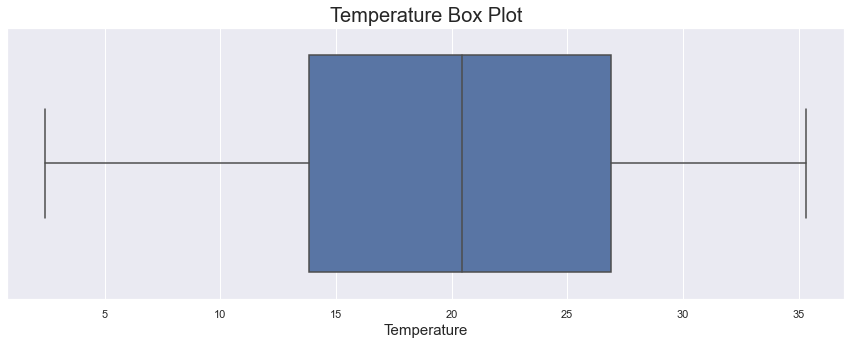

In [52]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=data, x='temp')
plt.title('Temperature Box Plot', fontdict={'fontsize': 20})
plt.xlabel('Temperature', fontdict={'fontsize': 15})

#### Temperature column is varied between a range which seems to be valid range, hence we can proceed ahead with this column without dropping / changing any records.

## 3.10 Humidity Column

In [53]:
data.hum.describe()

count    730.000000
mean      62.765175
std       14.237589
min        0.000000
25%       52.000000
50%       62.625000
75%       72.989575
max       97.250000
Name: hum, dtype: float64

Text(0.5, 0, 'Humidity')

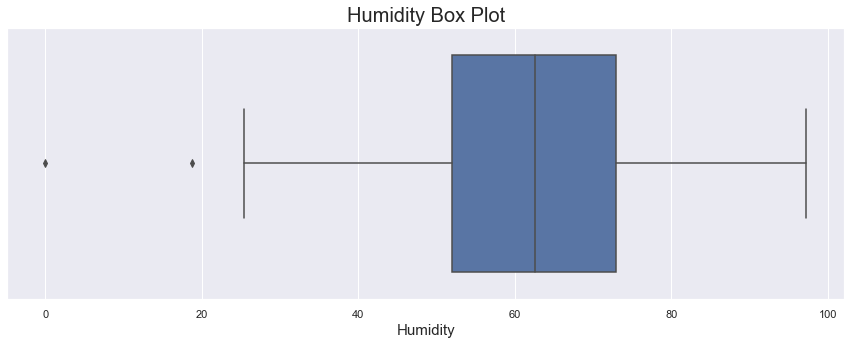

In [54]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=data, x='hum')
plt.title('Humidity Box Plot', fontdict={'fontsize': 20})
plt.xlabel('Humidity', fontdict={'fontsize': 15})

In [55]:
data[data['hum'] == 0]

,date,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,
69,10,spring,0,March,0,thursday,1,light,15.952731,0.0,17.545759,46,577,623


#### To check if this a typo or invalid data from source, we will pick 20% of values prior to specific date & 20% of values after the specific date and generate a plot to check the behaviour

In [56]:
humidity_check_df = data[(data.index > int(69*0.8)) & (data.index < int(69*1.2))]
humidity_check_df

,date,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,
56,25,spring,0,February,0,friday,1,mist,14.938268,71.2174,23.218113,120,1341,1461
57,26,spring,0,February,0,saturday,0,clear,11.582500,53.7917,12.500257,424,1545,1969
58,27,spring,0,February,0,sunday,0,clear,14.082598,68.0000,8.391616,694,1708,2402
59,28,spring,0,February,0,monday,1,mist,16.698193,87.6364,19.408962,81,1365,1446
60,1,spring,0,March,0,tuesday,1,clear,10.933347,53.5000,14.500475,137,1714,1851
61,2,spring,0,March,0,wednesday,1,clear,13.735000,44.9583,20.624811,231,1903,2134
62,3,spring,0,March,0,thursday,1,clear,8.131653,31.8333,15.125518,123,1562,1685
63,4,spring,0,March,0,friday,1,mist,10.728347,61.0417,13.624182,214,1730,1944
64,5,spring,0,March,0,saturday,0,mist,15.750847,78.9167,16.875357,640,1437,2077


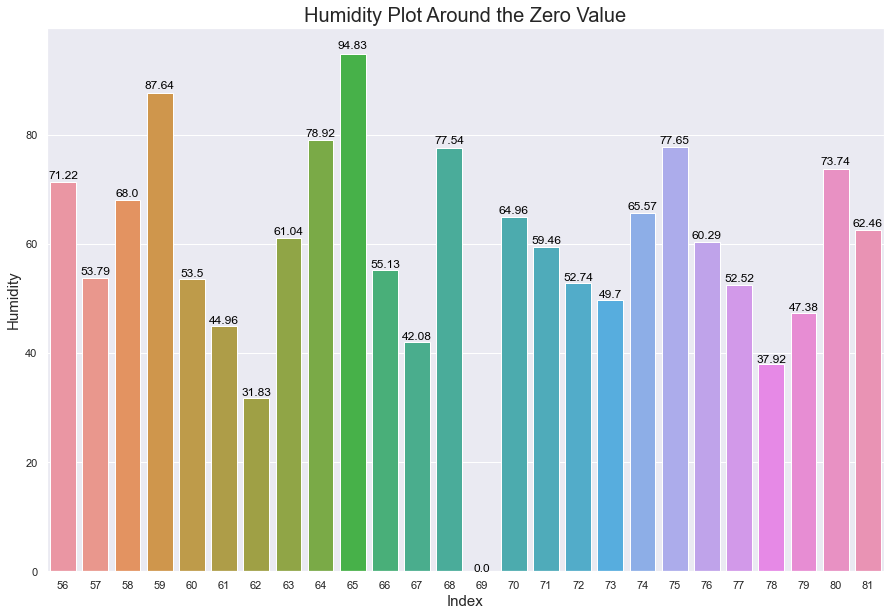

In [57]:
graph = sns.barplot(y=humidity_check_df.hum, x=humidity_check_df.index)
plt.title('Humidity Plot Around the Zero Value', fontdict={'fontsize': 20})
plt.xlabel('Index', fontdict={'fontsize': 15})
plt.ylabel('Humidity', fontdict={'fontsize': 15})
counter = 0
for index, row in humidity_check_df.iterrows():
    graph.text(counter, row.hum*1.01, round(row.hum, 2), color='black', ha="center")
    counter+=1
plt.show()

#### From the above graph we can say that, the value of humidity as 0 should be adjusted as humidity if 0 is practically impossible. This could have been possible during recording the data if not done properly.
#### This can be done by taking numerical mean of all the records before and after this value upto a specifc range making to make sure there is no abrupt change in the season that will again deem oour redicted value to be wrong.

#### Imputing the mean value at the zero humidity level

In [58]:
mean_value = humidity_check_df.hum.mean()
mean_value

58.64794230769231

In [59]:
#Replacing null values with mean value
data.at[int(data[data['hum'] == 0.0].hum.index.values), "hum"] = mean_value



#### Validating if the imputed value is present or not?

In [60]:
data[data.hum < 10]

,date,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,


In [61]:
humidity_check_post_df = data[(data.index > int(69*0.8)) & (data.index < int(69*1.2))]

humidity_check_post_df

,date,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,
56,25,spring,0,February,0,friday,1,mist,14.938268,71.217400,23.218113,120,1341,1461
57,26,spring,0,February,0,saturday,0,clear,11.582500,53.791700,12.500257,424,1545,1969
58,27,spring,0,February,0,sunday,0,clear,14.082598,68.000000,8.391616,694,1708,2402
59,28,spring,0,February,0,monday,1,mist,16.698193,87.636400,19.408962,81,1365,1446
60,1,spring,0,March,0,tuesday,1,clear,10.933347,53.500000,14.500475,137,1714,1851
61,2,spring,0,March,0,wednesday,1,clear,13.735000,44.958300,20.624811,231,1903,2134
62,3,spring,0,March,0,thursday,1,clear,8.131653,31.833300,15.125518,123,1562,1685
63,4,spring,0,March,0,friday,1,mist,10.728347,61.041700,13.624182,214,1730,1944
64,5,spring,0,March,0,saturday,0,mist,15.750847,78.916700,16.875357,640,1437,2077


#### So, we have adjusted the zero (or missing) value of Humidity successfully.

## 3.11 Windspeed Column

In [62]:
data.windspeed.describe()

count    730.000000
mean      12.763620
std        5.195841
min        1.500244
25%        9.041650
50%       12.125325
75%       15.625589
max       34.000021
Name: windspeed, dtype: float64

#### Wind speed seems to be in legitimate range, hence we can proceed ahead with this column without dropping / changing any records

## 3.12 Casual, Registered Count & Total Count

#### Our aim for this assignment is to predict the final count (irrespective of casual & registered count)
#### As these columns are not required, we will go ahead dropping these.

In [63]:
data = data.drop(columns=['casual', 'registered'])

##### Here, we complete proper data transformation of required columns and also dropping the columns which are are redundant and are of no use in predicting outcome

## 3.13 Pair-plot

##### We will create a Pairplot to get an overal gist of the entire data set.
##### But, since many of the columns are alredy mapped to some category, we will import the csv file again and do a few altercations confined to pair-plot graph only

In [64]:
pair_plot_data = pd.read_csv('day.csv', index_col='instant')

In [65]:
pair_plot_data['dteday'] = pair_plot_data['dteday'].apply(lambda x: int(x.split('-')[0]))
pair_plot_data = pair_plot_data.rename(columns={"dteday": "date"})
pair_plot_data['yr'] = pair_plot_data['yr'].map({0: 2018, 1:2019})
pair_plot_data = pair_plot_data.drop(columns=['atemp', 'casual', 'registered'])
pair_plot_data.at[int(pair_plot_data[pair_plot_data['hum'] == 0.0].hum.index.values), "hum"] = mean_value

In [66]:
pair_plot_data.head(10)

,date,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
instant,,,,,,,,,,,,
1,1,1,2018,1,0,6,0,2,14.110847,80.5833,10.749882,985
2,2,1,2018,1,0,0,0,2,14.902598,69.6087,16.652113,801
3,3,1,2018,1,0,1,1,1,8.050924,43.7273,16.636703,1349
4,4,1,2018,1,0,2,1,1,8.200000,59.0435,10.739832,1562
5,5,1,2018,1,0,3,1,1,9.305237,43.6957,12.522300,1600
6,6,1,2018,1,0,4,1,1,8.378268,51.8261,6.000868,1606
7,7,1,2018,1,0,5,1,2,8.057402,49.8696,11.304642,1510
8,8,1,2018,1,0,6,0,2,6.765000,53.5833,17.875868,959
9,9,1,2018,1,0,0,0,1,5.671653,43.4167,24.250650,822


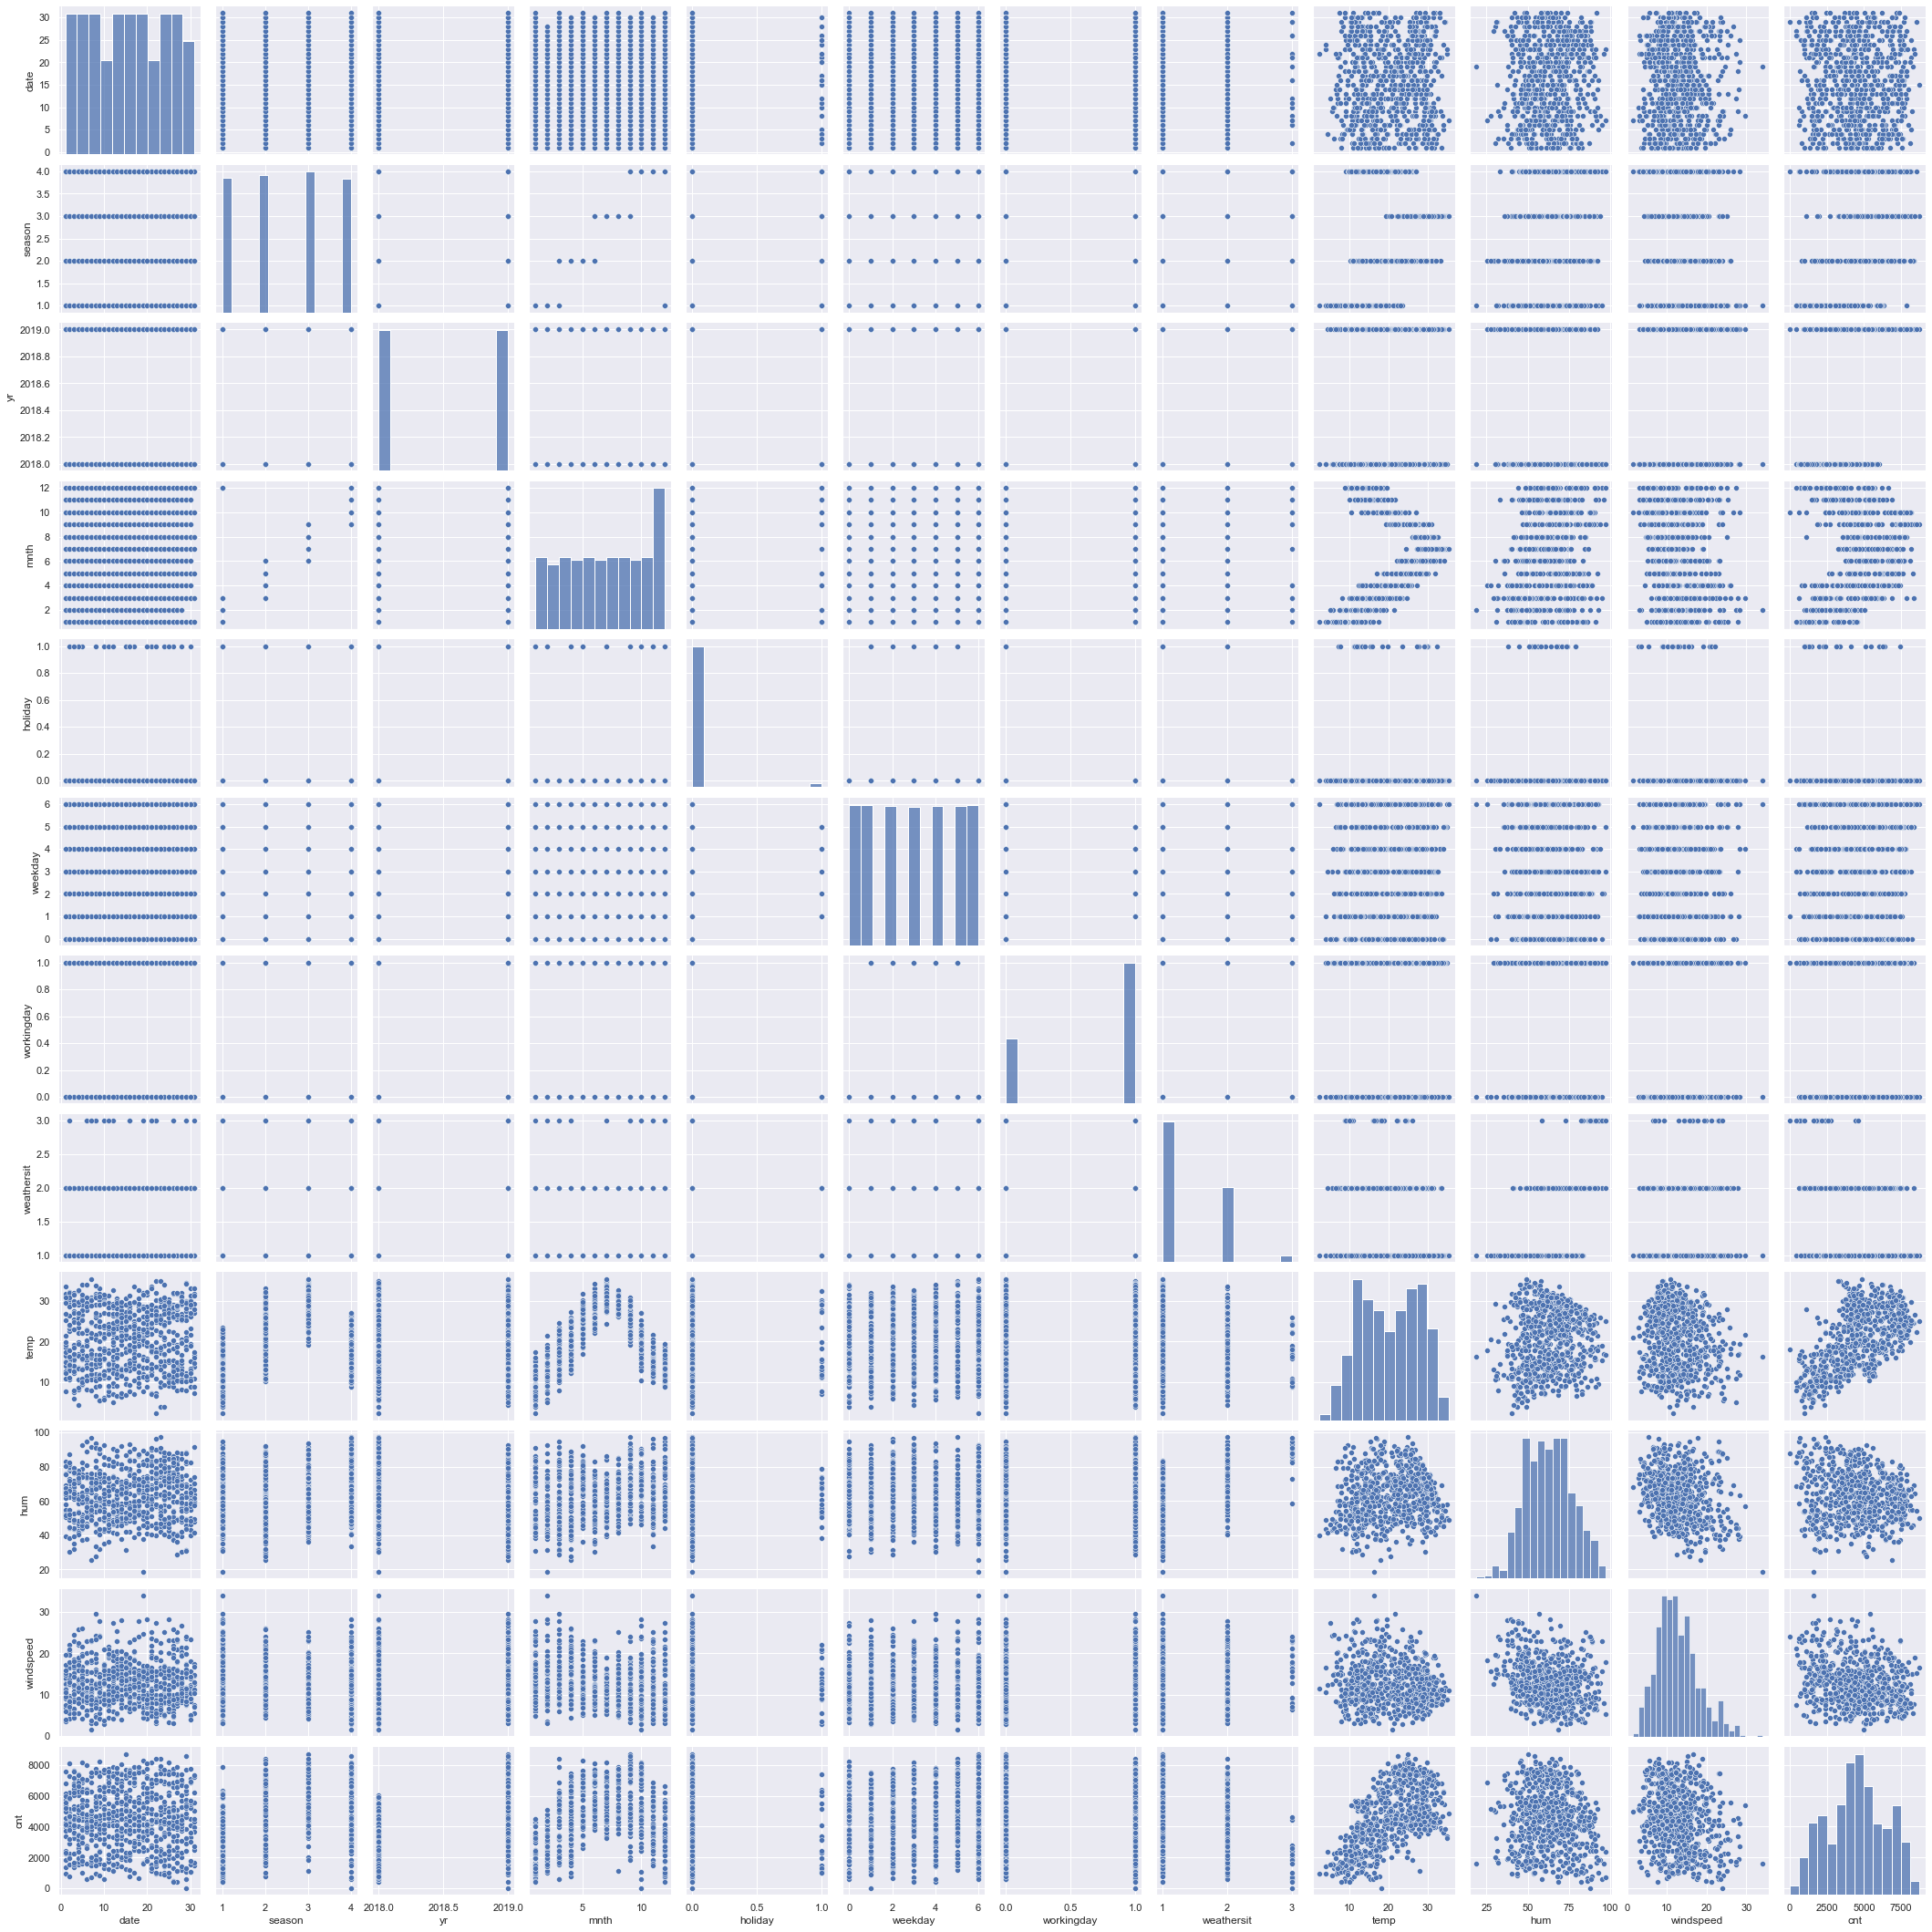

In [67]:
sns.pairplot(pair_plot_data)

**Following are the few assumptions that can hold up from the pairplot with respect to Count as Target Variable:**
- Date Column seems to be scattered evenly across all the points. Unable to make out any pattern when predicting Ride Count from the Date column alone.
- Ride Count Seems to be in maximum in Fall (Autumn) followed by Summer, Spring & Winter respectively.
- Ride Count has increased drastically in 2019 as compared to 2018
- Ride Count seems to increase between May to October which are comparatively Fall(Autumn) & Summer Season in US
- Ride Count is lesser on Holidays as compared to other days.
- Working Day / Non-Working Day shows almost similar behaviour (after just visualising the data)
- Ride Count is more on Clear & Misty Days as compared to Light Snow / Rainfall
- Ride Count seems to be very much lienarly dependent on Temperature
- Humidity & windspeed does not indicate any specific behaviour on just visualising the data.



# 4. Data Transformation (DUMMY VARIABLE)

#### Following Columns are Categorical Nominal Variables which needs to encoded using One Hot Encoder Method (i.e. Creating Dummy Variables):
- Month
- Season
- Weekday
- Weather Situation

In [68]:
dummy_variables_columns = ['mnth', 'season', 'weekday', 'weathersit']
dummy_variables_columns

['mnth', 'season', 'weekday', 'weathersit']

In [69]:
data[dummy_variables_columns].head()

,mnth,season,weekday,weathersit
instant,,,,
1,January,spring,saturday,mist
2,January,spring,sunday,mist
3,January,spring,monday,clear
4,January,spring,tuesday,clear
5,January,spring,wednesday,clear


In [70]:
pd.get_dummies(data[dummy_variables_columns])

,mnth_April,mnth_August,mnth_December,mnth_February,mnth_January,mnth_July,mnth_June,mnth_March,mnth_May,mnth_November,...,weekday_friday,weekday_monday,weekday_saturday,weekday_sunday,weekday_thursday,weekday_tuesday,weekday_wednesday,weathersit_clear,weathersit_light,weathersit_mist
instant,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
727,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
728,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [71]:
status = pd.get_dummies(data[dummy_variables_columns], drop_first=True)
status.head(10)

,mnth_August,mnth_December,mnth_February,mnth_January,mnth_July,mnth_June,mnth_March,mnth_May,mnth_November,mnth_October,...,season_summer,season_winter,weekday_monday,weekday_saturday,weekday_sunday,weekday_thursday,weekday_tuesday,weekday_wednesday,weathersit_light,weathersit_mist
instant,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
9,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [72]:
data = pd.concat([data, status], axis=1)
data

,date,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,...,season_summer,season_winter,weekday_monday,weekday_saturday,weekday_sunday,weekday_thursday,weekday_tuesday,weekday_wednesday,weathersit_light,weathersit_mist
instant,,,,,,,,,,,,,,,,,,,,,
1,1,spring,0,January,0,saturday,0,mist,14.110847,80.5833,...,0,0,0,1,0,0,0,0,0,1
2,2,spring,0,January,0,sunday,0,mist,14.902598,69.6087,...,0,0,0,0,1,0,0,0,0,1
3,3,spring,0,January,0,monday,1,clear,8.050924,43.7273,...,0,0,1,0,0,0,0,0,0,0
4,4,spring,0,January,0,tuesday,1,clear,8.200000,59.0435,...,0,0,0,0,0,0,1,0,0,0
5,5,spring,0,January,0,wednesday,1,clear,9.305237,43.6957,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,27,spring,1,December,0,thursday,1,mist,10.420847,65.2917,...,0,0,0,0,0,1,0,0,0,1
727,28,spring,1,December,0,friday,1,mist,10.386653,59.0000,...,0,0,0,0,0,0,0,0,0,1
728,29,spring,1,December,0,saturday,0,mist,10.386653,75.2917,...,0,0,0,1,0,0,0,0,0,1


In [73]:
data = data.drop(columns=dummy_variables_columns)
data

,date,yr,holiday,workingday,temp,hum,windspeed,cnt,mnth_August,mnth_December,...,season_summer,season_winter,weekday_monday,weekday_saturday,weekday_sunday,weekday_thursday,weekday_tuesday,weekday_wednesday,weathersit_light,weathersit_mist
instant,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,14.110847,80.5833,10.749882,985,0,0,...,0,0,0,1,0,0,0,0,0,1
2,2,0,0,0,14.902598,69.6087,16.652113,801,0,0,...,0,0,0,0,1,0,0,0,0,1
3,3,0,0,1,8.050924,43.7273,16.636703,1349,0,0,...,0,0,1,0,0,0,0,0,0,0
4,4,0,0,1,8.200000,59.0435,10.739832,1562,0,0,...,0,0,0,0,0,0,1,0,0,0
5,5,0,0,1,9.305237,43.6957,12.522300,1600,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,27,1,0,1,10.420847,65.2917,23.458911,2114,0,1,...,0,0,0,0,0,1,0,0,0,1
727,28,1,0,1,10.386653,59.0000,10.416557,3095,0,1,...,0,0,0,0,0,0,0,0,0,1
728,29,1,0,0,10.386653,75.2917,8.333661,1341,0,1,...,0,0,0,1,0,0,0,0,0,1


# 5. Data Splitting

#### Here, we will split the data into 2 parts
- 1. Train Data (On which model will be build and is almost 70% of total data)
- 2. Test Data (On which build model will be tested and is almost 30% of total data)

In [74]:
df_train, df_test = train_test_split(data, train_size=0.7, random_state=100)

In [75]:
df_train.shape

(510, 30)

In [76]:
df_test.shape

(220, 30)

# 6. Data Transformation (Normalising)

## 6.1 Defining Numerical Variable Columns that should be scaled directly

#### Following Columns are Numerical which needs to be Normalised:
- Date
- Temperature
- Humidity
- Windspeed

In [77]:
numerical_variables = ['date', 'temp', 'hum', 'windspeed', 'cnt']

In [78]:
scaler = MinMaxScaler()

In [79]:
df_train[numerical_variables]

,date,temp,hum,windspeed,cnt
instant,,,,,
577,31,29.246653,70.4167,11.083475,7216
427,3,16.980847,62.1250,10.792293,4066
729,30,10.489153,48.3333,23.500518,1796
483,28,15.443347,48.9583,8.708325,4220
112,22,13.803347,72.9583,14.707907,1683
...,...,...,...,...,...
579,2,30.852500,65.9583,8.666718,7261
54,23,9.091299,42.3043,6.305571,1917
351,17,10.591653,56.0833,16.292189,2739


In [80]:
df_train[numerical_variables] = scaler.fit_transform(df_train[numerical_variables])
df_train.head(10)

,date,yr,holiday,workingday,temp,hum,windspeed,cnt,mnth_August,mnth_December,...,season_summer,season_winter,weekday_monday,weekday_saturday,weekday_sunday,weekday_thursday,weekday_tuesday,weekday_wednesday,weathersit_light,weathersit_mist
instant,,,,,,,,,,,,,,,,,,,,,
577,1.000000,1,0,1,0.815169,0.659744,0.264686,0.827658,0,0,...,0,0,0,0,0,0,1,0,0,0
427,0.066667,1,0,0,0.442393,0.553780,0.255342,0.465255,0,0,...,0,0,0,1,0,0,0,0,0,1
729,0.966667,1,0,0,0.245101,0.377528,0.663106,0.204096,0,1,...,0,0,0,0,1,0,0,0,0,0
483,0.900000,1,0,0,0.395666,0.385516,0.188475,0.482973,0,0,...,1,0,0,1,0,0,0,0,0,1
112,0.700000,0,0,1,0.345824,0.692225,0.380981,0.191095,0,0,...,1,0,0,0,0,0,0,0,0,1
581,0.100000,1,0,0,0.914852,0.543663,0.462538,0.782559,1,0,...,0,0,0,1,0,0,0,0,0,0
501,0.500000,1,0,1,0.719639,0.651757,0.172431,0.851588,0,0,...,1,0,0,0,0,0,0,1,0,0
480,0.800000,1,0,1,0.520271,0.306709,0.164434,0.710308,0,0,...,1,0,0,0,0,0,0,1,0,0
473,0.566667,1,0,1,0.503656,0.487220,0.270032,0.499885,0,0,...,1,0,0,0,0,0,0,1,0,1


# 7. Manual Analysis of Variable (using Correlaion-Co-efficient)

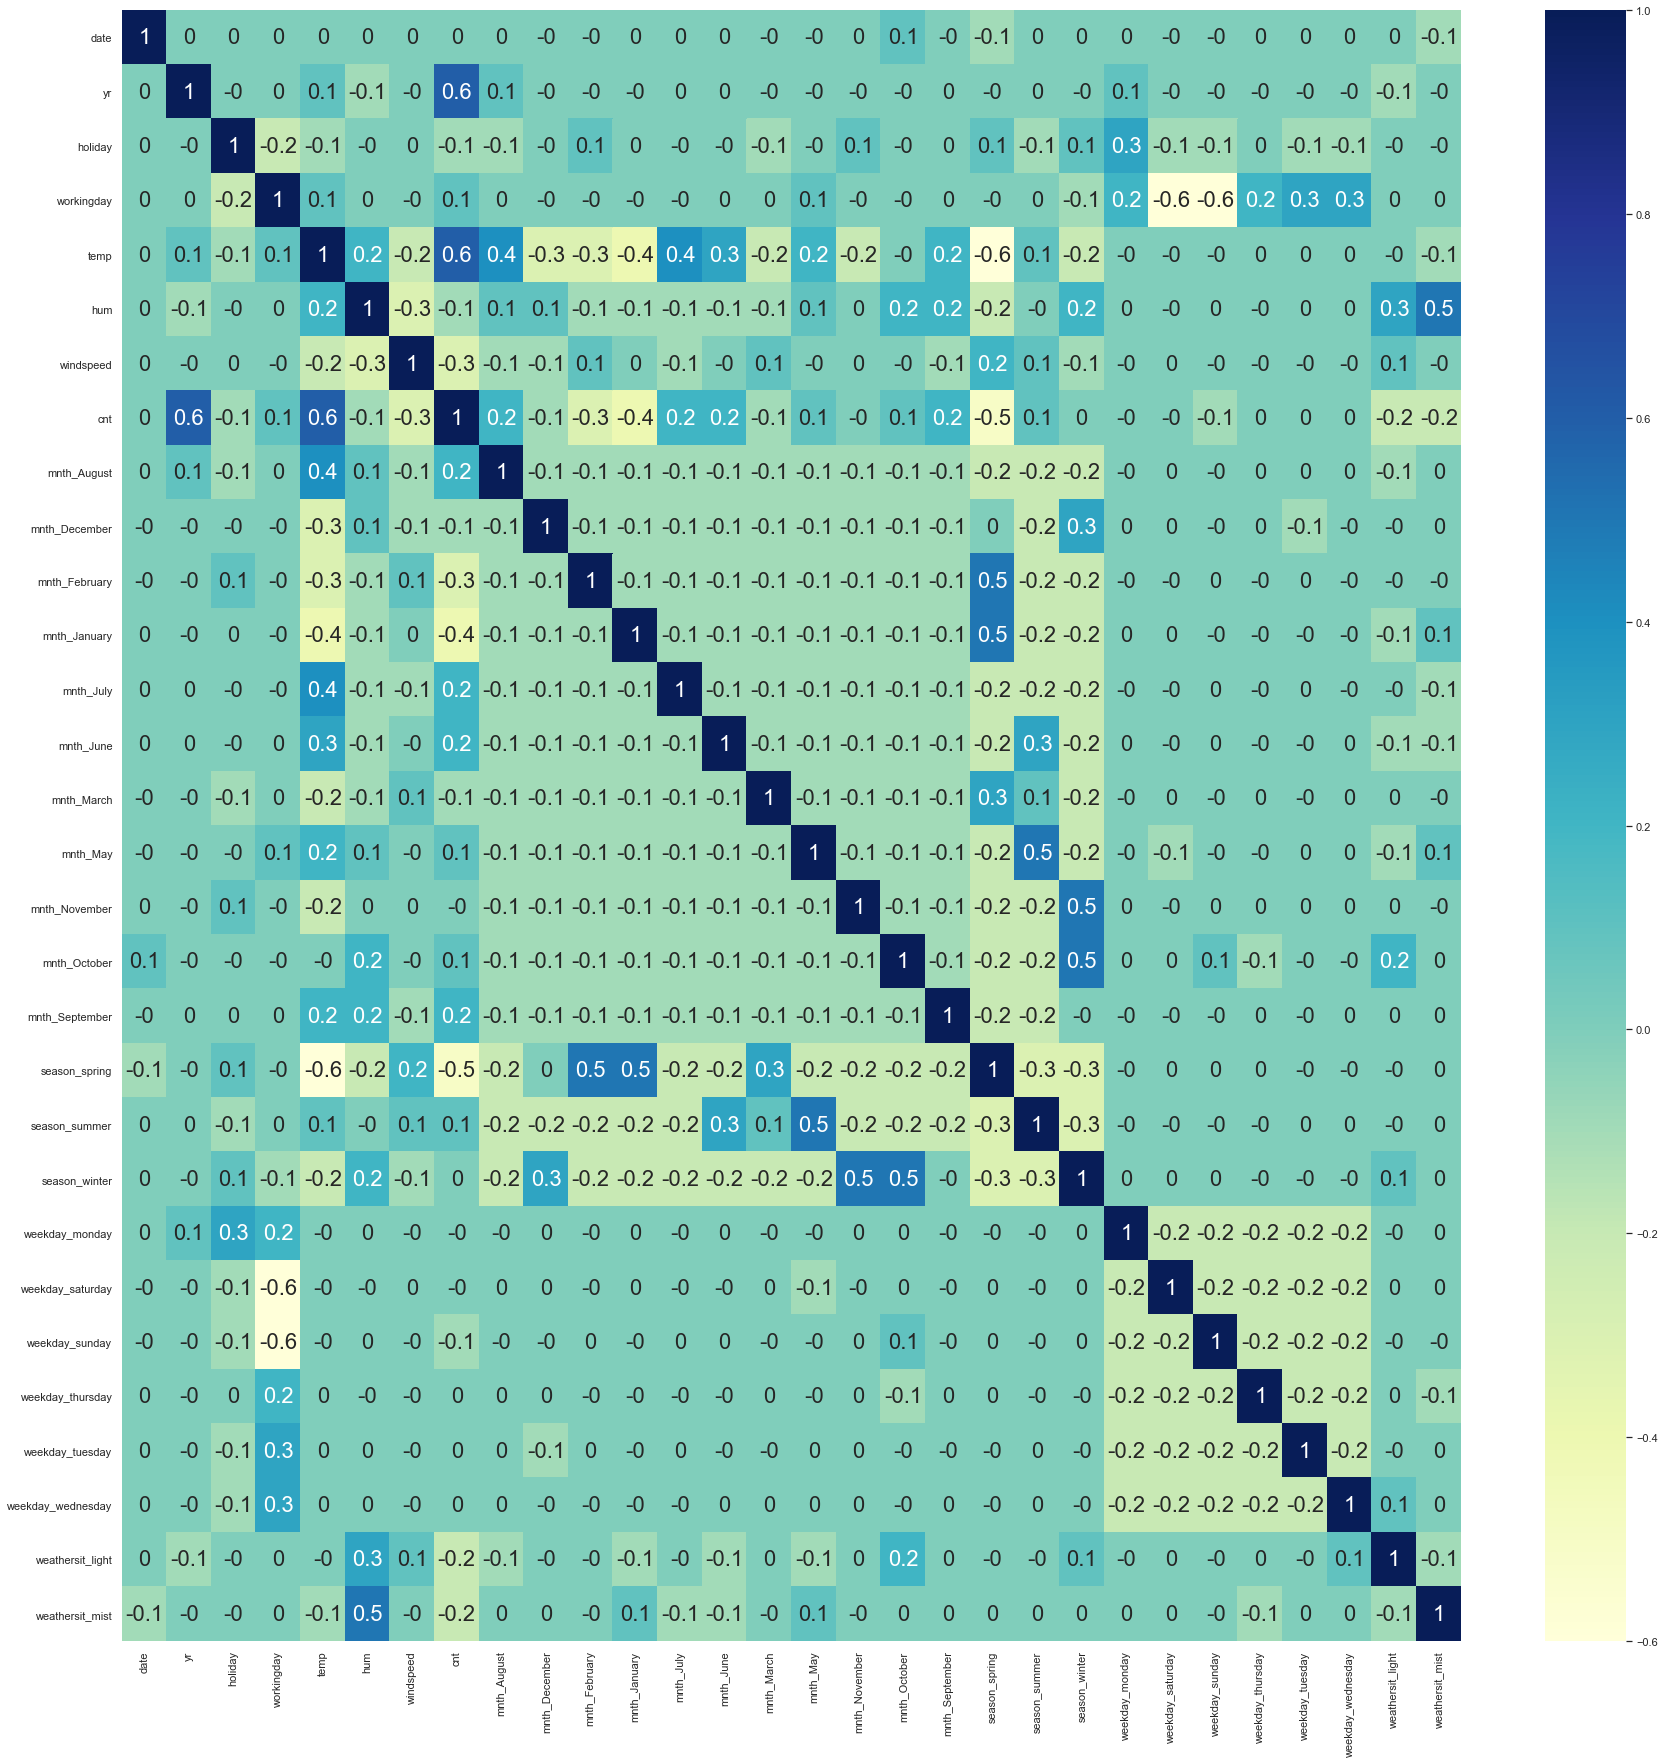

In [81]:
df_train.corr()
plt.figure(figsize=(30, 30))
sns.heatmap(round(df_train.corr(), 1), annot=True, cmap='YlGnBu',annot_kws={'size': 22})
sns.set(font_scale=3)

#### From the above Correlation Coefficient Hatmap, we see that no variable is highly correlated with another variable in any way. So, we can further proceed and check Multi-Collinearity while creating models itself

# 8. Defining Target & Feature Variables for Iterative Modelling Process

### 8.1. Fixing Trained Target Variable

In [82]:
y_train = df_train.pop('cnt')

### 8.2. Fixing Trained Feature(s) Variable

In [83]:
X_train = df_train

# 9. Iterative Modeling Process

#### Currently, we have almost 30 Predictors to Predict our outcome. Analysing these many predictors can be very hectic.
#### To simplify this process, we will use RFE (Recursive Feature Elimination) method to which will provide us with set of variables ranked in an order of importance (of impacting outcome)
#### We will pass an arbitary number (here 15), which means the method will rank first 15 predictors as 1 & remaining as 0.

##### Creating a generalised function for evaluating Variance Inflation Factor

In [84]:
def fetch_vif_df(local_df):
    vif_df = pd.DataFrame()
    vif_df['Features'] = local_df.columns
    vif_df['VIF'] = [variance_inflation_factor(local_df.values, i) for i in range(local_df.shape[1])]
    vif_df['VIF'] = round(vif_df['VIF'], 2)
    vif_df = vif_df.sort_values(by='VIF', ascending=False)
    vif_df = vif_df.reset_index(drop=True)
    return vif_df

### 9.1. RFE (Recursive Feature Elimination) Application

In [85]:
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm, 15)
rfe = rfe.fit(X_train, y_train)

In [86]:
rfe_df = pd.DataFrame({'Predictor': X_train.columns, 'Select Status': rfe.support_, 'Ranking': rfe.ranking_})
rfe_df.sort_values(by='Ranking')

,Predictor,Select Status,Ranking
28,weathersit_mist,True,1
19,season_summer,True,1
27,weathersit_light,True,1
20,season_winter,True,1
22,weekday_saturday,True,1
11,mnth_July,True,1
17,mnth_September,True,1
18,season_spring,True,1
6,windspeed,True,1
5,hum,True,1


#### RFE method has successfully evaluated top 15 predictors which will impact our outcome.
#### But, we will not rely on this enitirely and continue validating this 15 features manually by building model one by one and elimating any feature which does not satisfy our requirements

### 9.2. Model Building Process - 1

In [87]:
col = X_train.columns[rfe.support_]
X_train_rfe = X_train[col]
X_train_sm = sm.add_constant(X_train_rfe)
lr = sm.OLS(y_train, X_train_sm)
lr_model = lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     195.8
Date:                Tue, 06 Jul 2021   Prob (F-statistic):          2.02e-191
Time:                        23:45:43   Log-Likelihood:                 517.65
No. Observations:                 510   AIC:                            -1005.
Df Residuals:                     495   BIC:                            -941.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1759      0.025      6.981      0.000       0.126       0.225
yr                   0.2292      0.008     28.520      0.000       0.213       0.245
holiday             -0.0243      0.021     -1.154      0.249      -0.066       0.017
workingday           0.0779      0.009      8.430      0.000       0.060       0.096
temp                 0.5321      0.033     15.891      0.000       0.466       0.598
hum                 -0.1386      0.032     -4.322      0.000      -0.202      -0.076
windspeed           -0.1829      0.026     -7.160      0.000      -0.233      -0.133
mnth_July           -0.0552      0.018     -3.050      0.002      -0.091      -0.020
mnth_September       0.0822      0.017      4.980      0.000       0.050       0.115
season_spring       -0.0531      0.021     -2.572      0.010      -0.094      -0.013
season_summer        0.0545      0.015      3.678      0.000       0.025       0.084
season_winter        0.1005      0.017      5.870      0.000       0.067       0.134
weekday_saturday     0.0874      0.011      7.710      0.000       0.065       0.110
weekday_sunday       0.0349      0.012      2.944      0.003       0.012       0.058
weathersit_light    -0.2349      0.027     -8.676      0.000      -0.288      -0.182
weathersit_mist     -0.0546      0.011     -5.141      0.000      -0.075      -0.034
==============================================================================
Omnibus:                       65.223   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              157.208
Skew:                          -0.668   Prob(JB):                     7.29e-35
Kurtosis:                       5.369   Cond. No.                     1.65e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.39e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [88]:
fetch_vif_df(X_train_rfe)

,Features,VIF
0,workingday,41.74
1,weekday_saturday,10.18
2,weekday_sunday,9.81
3,season_spring,5.05
4,temp,3.67
5,season_winter,3.51
6,season_summer,2.63
7,holiday,2.57
8,hum,2.08
9,weathersit_mist,1.64


#### In the above model we see that P-Value of "Holiday" feature is more than 0.05, which make its co-efficient insignificant.
#### So, we will proceed ahead with dropping this feature and designing model again.

### 9.3. Model Building Process - 2

#### Dropping Holiday feature and designing model again

In [89]:
col = col.drop(['holiday'])
X_train_rfe = X_train[col]
X_train_sm = sm.add_constant(X_train_rfe)
lr = sm.OLS(y_train, X_train_sm)
lr_model = lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     195.8
Date:                Tue, 06 Jul 2021   Prob (F-statistic):          2.02e-191
Time:                        23:45:44   Log-Likelihood:                 517.65
No. Observations:                 510   AIC:                            -1005.
Df Residuals:                     495   BIC:                            -941.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1516      0.040      3.833      0.000       0.074       0.229
yr                   0.2292      0.008     28.520      0.000       0.213       0.245
workingday           0.1022      0.025      4.028      0.000       0.052       0.152
temp                 0.5321      0.033     15.891      0.000       0.466       0.598
hum                 -0.1386      0.032     -4.322      0.000      -0.202      -0.076
windspeed           -0.1829      0.026     -7.160      0.000      -0.233      -0.133
mnth_July           -0.0552      0.018     -3.050      0.002      -0.091      -0.020
mnth_September       0.0822      0.017      4.980      0.000       0.050       0.115
season_spring       -0.0531      0.021     -2.572      0.010      -0.094      -0.013
season_summer        0.0545      0.015      3.678      0.000       0.025       0.084
season_winter        0.1005      0.017      5.870      0.000       0.067       0.134
weekday_saturday     0.1117      0.027      4.167      0.000       0.059       0.164
weekday_sunday       0.0592      0.027      2.197      0.029       0.006       0.112
weathersit_light    -0.2349      0.027     -8.676      0.000      -0.288      -0.182
weathersit_mist     -0.0546      0.011     -5.141      0.000      -0.075      -0.034
==============================================================================
Omnibus:                       65.223   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              157.208
Skew:                          -0.668   Prob(JB):                     7.29e-35
Kurtosis:                       5.369   Cond. No.                         24.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [90]:
fetch_vif_df(X_train_rfe)

,Features,VIF
0,hum,21.36
1,temp,17.84
2,workingday,17.18
3,windspeed,5.05
4,weekday_saturday,4.63
5,season_spring,4.51
6,weekday_sunday,4.48
7,season_winter,3.47
8,season_summer,2.95
9,weathersit_mist,2.47


#### From the above observations, we see that the p-values of all features are under control. So we will proceed ahead to VIF table

#### In the VIF table, we see that Humidity column seems to be explained by some other feature. So we will again drop this humidity feature and design our model.

### 9.4. Model Building Process - 3

#### Dropping Humidity feature and designing model again

In [91]:
col = col.drop(['hum'])
X_train_rfe = X_train[col]
X_train_sm = sm.add_constant(X_train_rfe)
lr = sm.OLS(y_train, X_train_sm)
lr_model = lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     202.2
Date:                Tue, 06 Jul 2021   Prob (F-statistic):          1.28e-188
Time:                        23:45:44   Log-Likelihood:                 508.20
No. Observations:                 510   AIC:                            -988.4
Df Residuals:                     496   BIC:                            -929.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1008      0.038      2.624      0.009       0.025       0.176
yr                   0.2337      0.008     28.828      0.000       0.218       0.250
workingday           0.1029      0.026      3.983      0.000       0.052       0.154
temp                 0.4915      0.033     15.027      0.000       0.427       0.556
windspeed           -0.1491      0.025     -6.024      0.000      -0.198      -0.100
mnth_July           -0.0496      0.018     -2.702      0.007      -0.086      -0.014
mnth_September       0.0759      0.017      4.537      0.000       0.043       0.109
season_spring       -0.0655      0.021     -3.147      0.002      -0.106      -0.025
season_summer        0.0477      0.015      3.180      0.002       0.018       0.077
season_winter        0.0846      0.017      4.971      0.000       0.051       0.118
weekday_saturday     0.1146      0.027      4.201      0.000       0.061       0.168
weekday_sunday       0.0567      0.027      2.069      0.039       0.003       0.111
weathersit_light    -0.2895      0.024    -11.880      0.000      -0.337      -0.242
weathersit_mist     -0.0822      0.009     -9.514      0.000      -0.099      -0.065
==============================================================================
Omnibus:                       66.828   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              162.148
Skew:                          -0.682   Prob(JB):                     6.17e-36
Kurtosis:                       5.402   Cond. No.                         22.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [92]:
fetch_vif_df(X_train_rfe)

,Features,VIF
0,workingday,16.19
1,temp,12.74
2,windspeed,4.76
3,weekday_saturday,4.45
4,weekday_sunday,4.21
5,season_spring,3.82
6,season_winter,2.78
7,season_summer,2.76
8,yr,2.07
9,mnth_July,1.60


#### From the above observations, we see that the p-values of all features are under control. So we will proceed ahead to VIF table

#### In the VIF table, we see that Working Day column seems to be explained by some other feature. So we will again drop this humidity feature and design our model.

### 9.5. Model Building Process - 4

#### Dropping Working Day feature and designing model again

In [93]:
col = col.drop(['workingday'])
X_train_rfe = X_train[col]
X_train_sm = sm.add_constant(X_train_rfe)
lr = sm.OLS(y_train, X_train_sm)
lr_model = lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     211.4
Date:                Tue, 06 Jul 2021   Prob (F-statistic):          2.06e-186
Time:                        23:45:44   Log-Likelihood:                 500.18
No. Observations:                 510   AIC:                            -974.4
Df Residuals:                     497   BIC:                            -919.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2003      0.030      6.760      0.000       0.142       0.259
yr                   0.2342      0.008     28.467      0.000       0.218       0.250
temp                 0.4928      0.033     14.847      0.000       0.428       0.558
windspeed           -0.1513      0.025     -6.025      0.000      -0.201      -0.102
mnth_July           -0.0488      0.019     -2.618      0.009      -0.085      -0.012
mnth_September       0.0723      0.017      4.264      0.000       0.039       0.106
season_spring       -0.0681      0.021     -3.225      0.001      -0.110      -0.027
season_summer        0.0481      0.015      3.159      0.002       0.018       0.078
season_winter        0.0816      0.017      4.731      0.000       0.048       0.116
weekday_saturday     0.0157      0.011      1.370      0.171      -0.007       0.038
weekday_sunday      -0.0421      0.012     -3.548      0.000      -0.065      -0.019
weathersit_light    -0.2848      0.025    -11.530      0.000      -0.333      -0.236
weathersit_mist     -0.0802      0.009     -9.170      0.000      -0.097      -0.063
==============================================================================
Omnibus:                       80.355   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              207.836
Skew:                          -0.790   Prob(JB):                     7.39e-46
Kurtosis:                       5.699   Cond. No.                         17.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [94]:
fetch_vif_df(X_train_rfe)

,Features,VIF
0,temp,5.18
1,windspeed,4.62
2,season_summer,2.24
3,season_spring,2.11
4,yr,2.07
5,season_winter,1.82
6,mnth_July,1.59
7,weathersit_mist,1.55
8,mnth_September,1.33
9,weekday_saturday,1.22


#### In the above model we see that P-Value of "weekday_saturday" feature is more than 0.05, which make its co-efficient insignificant.
#### So, we will proceed ahead with dropping this feature and designing model again.

### 9.6. Model Building Process - 5

#### Dropping Weekday Saturday feature and designing model again

In [95]:
col = col.drop(['weekday_saturday'])
X_train_rfe = X_train[col]
X_train_sm = sm.add_constant(X_train_rfe)
lr = sm.OLS(y_train, X_train_sm)
lr_model = lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     230.0
Date:                Tue, 06 Jul 2021   Prob (F-statistic):          3.37e-187
Time:                        23:45:44   Log-Likelihood:                 499.22
No. Observations:                 510   AIC:                            -974.4
Df Residuals:                     498   BIC:                            -923.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2034      0.030      6.877      0.000       0.145       0.261
yr                   0.2339      0.008     28.414      0.000       0.218       0.250
temp                 0.4917      0.033     14.805      0.000       0.426       0.557
windspeed           -0.1497      0.025     -5.963      0.000      -0.199      -0.100
mnth_July           -0.0483      0.019     -2.587      0.010      -0.085      -0.012
mnth_September       0.0723      0.017      4.260      0.000       0.039       0.106
season_spring       -0.0682      0.021     -3.227      0.001      -0.110      -0.027
season_summer        0.0479      0.015      3.145      0.002       0.018       0.078
season_winter        0.0818      0.017      4.739      0.000       0.048       0.116
weekday_sunday      -0.0450      0.012     -3.847      0.000      -0.068      -0.022
weathersit_light    -0.2847      0.025    -11.513      0.000      -0.333      -0.236
weathersit_mist     -0.0802      0.009     -9.161      0.000      -0.097      -0.063
==============================================================================
Omnibus:                       75.768   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              204.623
Skew:                          -0.732   Prob(JB):                     3.69e-45
Kurtosis:                       5.736   Cond. No.                         17.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [96]:
fetch_vif_df(X_train_rfe)

,Features,VIF
0,temp,5.14
1,windspeed,4.60
2,season_summer,2.23
3,season_spring,2.09
4,yr,2.07
5,season_winter,1.80
6,mnth_July,1.59
7,weathersit_mist,1.55
8,mnth_September,1.33
9,weekday_sunday,1.17


#### From the Model Summary Report we can say that all the p-values of respective features are well under control

##### Note: It is a hurestic approach that, if VIF value of any predictor is between 5 & 10, it is recommended to scrutinize such variable from business perspective and analyse any outliers & drop such feature if VIF is greater than 10

#### We see that all the features under VIF table are well under control, so we can fix the features available for our model

# 10. Proof for Linear Regrssion Assumptions

### 10.1. Assumption of Normally Distributed Error Terms

#### After building model, we cannot finalise untill we prove the residual analysis wherein we check whether the distribution of Error is around 0 or not.

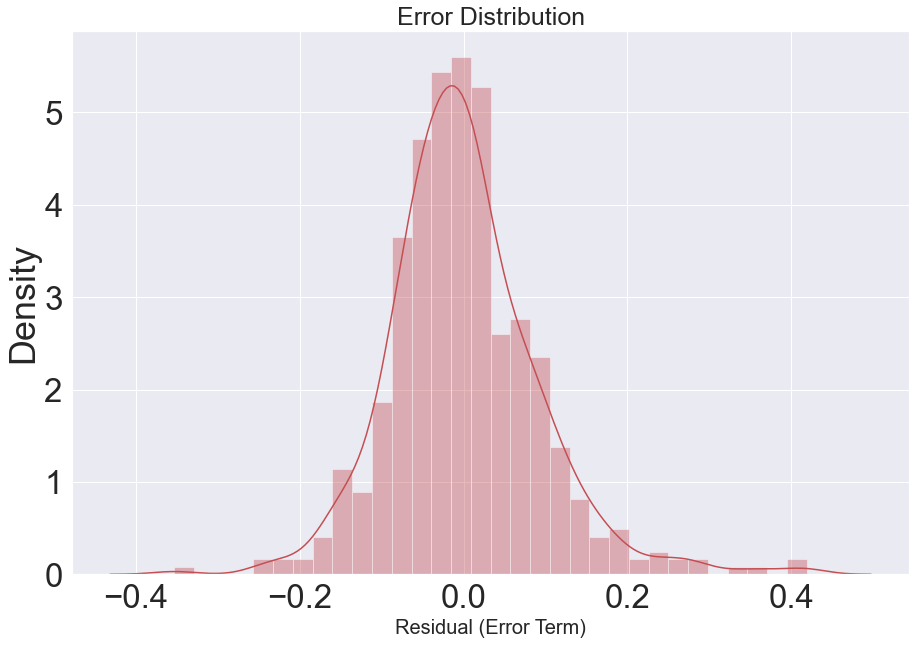

In [97]:
y_train_pred = lr_model.predict(X_train_sm)
residual = y_train_pred - y_train
sns.distplot(residual,color='r')
plt.xlabel('Residual (Error Term)', fontdict={'fontsize': 20})
plt.title('Error Distribution', fontdict={'fontsize': 25})
plt.show()

##### Note: From the above graph it is evident that Error Distribution Is Normallly Distributed Across 0, which indicates that our model has handled the assumption of Error Normal Distribution properly.

### 10.2. Assumption of Error Terms Being Independent

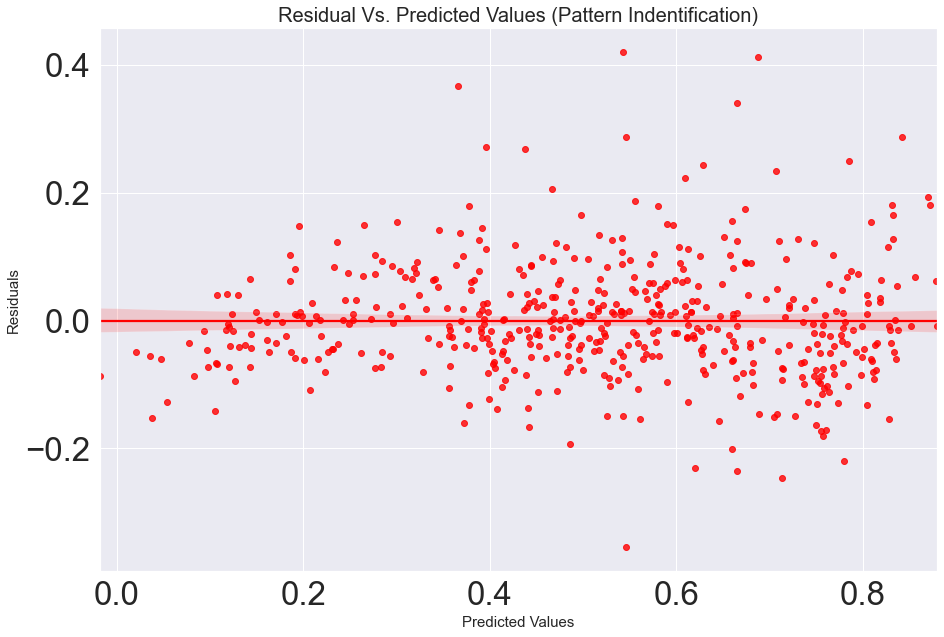

In [98]:
sns.regplot(x=y_train_pred, y=residual,color='red')
plt.title('Residual Vs. Predicted Values (Pattern Indentification)', fontdict={'fontsize': 20})
plt.xlabel('Predicted Values', fontdict={'fontsize': 15})
plt.ylabel('Residuals', fontdict={'fontsize': 15})
plt.show()

In [99]:
print("Pearson Value for Predicted Value Against Residual ==>", pearsonr(y_train_pred, residual)[0])

Pearson Value for Predicted Value Against Residual ==> 1.7338561142388187e-15


#### From the above graph, we see that there is almost no relation between Residual & Predicted Value. This is what we had expected from our model to have no specific pattern.

### 10.3. Homoscedasticity

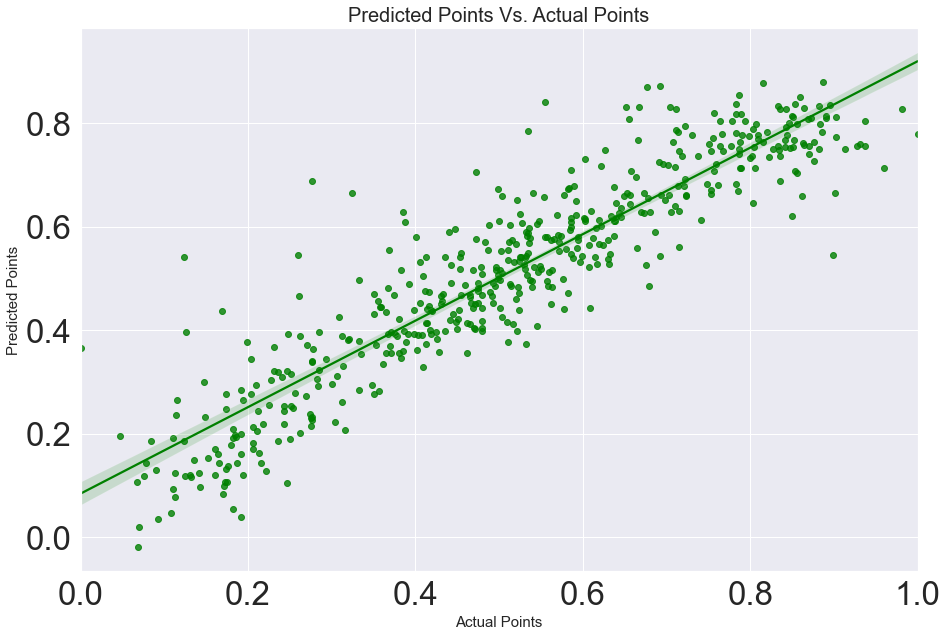

In [100]:
sns.regplot(x=y_train, y=y_train_pred,color='green')
plt.title('Predicted Points Vs. Actual Points', fontdict={'fontsize': 20})
plt.xlabel('Actual Points', fontdict={'fontsize': 15})
plt.ylabel('Predicted Points', fontdict={'fontsize': 15})
plt.show()

#### From the above graph, we can say that residuals are equal distributed across predicted value.
#### This means we see equal variance and we do NOT observe high concentration of data points in certain region & low conecentarion in certain regions.
#### This prooves Homoscedasticity of Error Terms

### 10.4 Multicorrelation

#### This asumption is already taken care of while building model by calculating VIF of evry predictor. Following is the final VIF value of all the predictors used in the model

In [101]:
fetch_vif_df(X_train_rfe)

,Features,VIF
0,temp,5.14
1,windspeed,4.60
2,season_summer,2.23
3,season_spring,2.09
4,yr,2.07
5,season_winter,1.80
6,mnth_July,1.59
7,weathersit_mist,1.55
8,mnth_September,1.33
9,weekday_sunday,1.17


#### Evaluating Correlation Co-efficients of Predictors Impacting Target Variable (Individually)

In [102]:
corr_dict = {index: round(pearsonr(y_train, X_train_rfe[index])[0], 2) for index in X_train_rfe.columns}
corr_df = pd.DataFrame(corr_dict.values(), index=corr_dict.keys(), columns=['Correlation_Coefficient'])
corr_df.iloc[(-corr_df['Correlation_Coefficient'].abs()).argsort()]

,Correlation_Coefficient
temp,0.65
yr,0.59
season_spring,-0.55
windspeed,-0.25
weathersit_light,-0.23
mnth_September,0.20
weathersit_mist,-0.17
mnth_July,0.16
season_summer,0.14
weekday_sunday,-0.06


# 11. Predicting on Test Data

In [103]:
df_test[numerical_variables] = scaler.transform(df_test[numerical_variables])
df_test.head(10)

,date,yr,holiday,workingday,temp,hum,windspeed,cnt,mnth_August,mnth_December,...,season_summer,season_winter,weekday_monday,weekday_saturday,weekday_sunday,weekday_thursday,weekday_tuesday,weekday_wednesday,weathersit_light,weathersit_mist
instant,,,,,,,,,,,,,,,,,,,,,
185,0.100000,0,1,0,0.831783,0.575080,0.084219,0.692706,0,0,...,0,0,1,0,0,0,0,0,0,1
536,0.633333,1,0,1,0.901354,0.516506,0.153728,0.712034,0,0,...,1,0,0,0,0,0,0,1,0,0
300,0.866667,0,0,1,0.511964,0.798722,0.334206,0.303382,0,0,...,0,1,0,0,0,1,0,0,0,1
222,0.300000,0,0,1,0.881625,0.301917,0.339570,0.547400,1,0,...,0,0,0,0,0,0,0,1,0,0
153,0.033333,0,0,1,0.817246,0.149627,0.537414,0.569029,0,0,...,1,0,0,0,0,1,0,0,0,0
405,0.266667,1,0,1,0.256524,0.478167,0.326196,0.438104,0,0,...,0,0,0,0,0,1,0,0,0,0
199,0.566667,0,0,1,0.856704,0.592119,0.372990,0.510354,0,0,...,0,0,1,0,0,0,0,0,0,0
172,0.666667,0,0,1,0.774672,0.744409,0.276724,0.553728,0,0,...,0,0,0,0,0,0,1,0,0,1
513,0.900000,1,1,0,0.814131,0.624068,0.331536,0.692706,0,0,...,1,0,1,0,0,0,0,0,0,0


### 11.1. Fixing Test Target Variable

In [104]:
y_test = df_test.pop('cnt')

### 11.2. Fixing Test Feature(s) Variable

In [105]:
X_test = df_test

### 11.3 Filtering Test Input (& Reserving Required Features Only)

In [106]:
X_test_new = X_test[X_train_rfe.columns]
X_test_new = sm.add_constant(X_test_new)

### 11.4 Predicting Test Data Using Developed Model

In [107]:
y_pred = lr_model.predict(X_test_new)

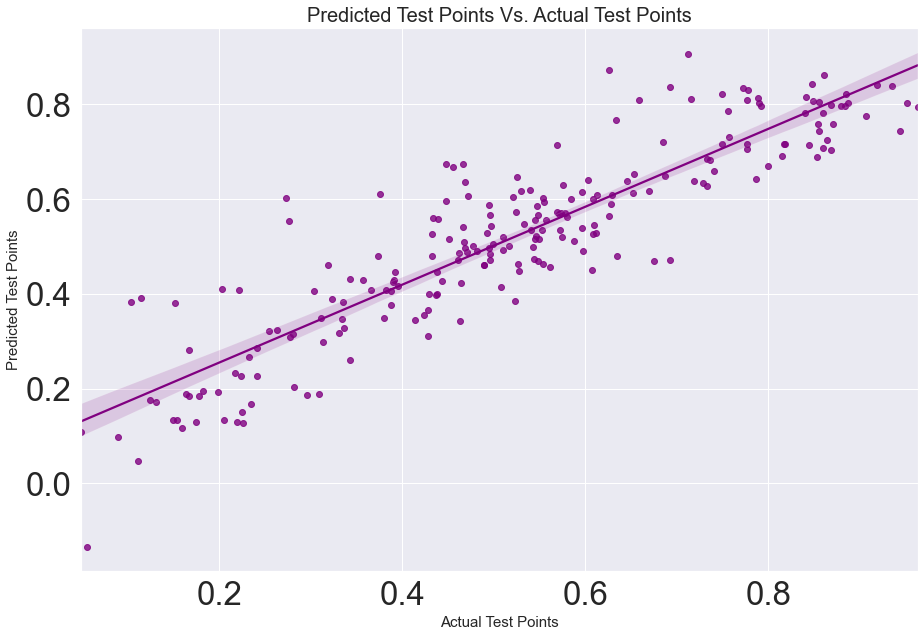

In [108]:
corr_plot = sns.regplot(x=y_test, y=y_pred,color='purple')
plt.title('Predicted Test Points Vs. Actual Test Points', fontdict={'fontsize': 20})
plt.xlabel('Actual Test Points', fontdict={'fontsize': 15})
plt.ylabel('Predicted Test Points', fontdict={'fontsize': 15})
plt.show()

#### Above Scatter Plot Shows Linear Relationship between Actual Test Data Points & Predicted Test Data Points

# 12. Generating R-Square

In [109]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.8057616301094371